<a href="https://colab.research.google.com/github/TaeWoongYoun/dataAnalysis/blob/main/%EC%A0%95%EC%8B%A0%EC%A7%88%ED%99%98%ED%85%8C%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!apt-get -qq install -y fonts-nanum

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [10]:
import pandas as pd

mental_df = pd.read_csv("정신질환.csv", encoding="cp949")
dementia_df = pd.read_csv("치매.csv", encoding="cp949")

import re

def extract_age(text):
    digits = re.findall(r'\d+', str(text))
    return int(digits[0]) if digits else -1

mental_df["연령숫자"] = mental_df["연령구분"].apply(extract_age)
dementia_df["연령숫자"] = dementia_df["연령군"].apply(extract_age)

mental_df = mental_df[mental_df["연령숫자"] >= 50].copy()
dementia_df = dementia_df[dementia_df["연령숫자"] >= 50].copy()

def age_group(age):
    if age >= 90:
        return "90세 이상"
    elif age >= 80:
        return "80대"
    elif age >= 70:
        return "70대"
    elif age >= 60:
        return "60대"
    else:
        return "50대"

mental_df["연령대"] = mental_df["연령숫자"].apply(age_group)
dementia_df["연령대"] = dementia_df["연령숫자"].apply(age_group)

mental_df.head()

,진료년도,상별구분,시도,시군구,성별,연령구분,환자수,입내원일수,요양급여비용,연령숫자,연령대
5,2018,ADHD,서울,강남구,남,50~59세,20,131,8719580,50,50대
6,2018,ADHD,서울,강남구,남,60~69세,0,0,0,60,60대
7,2018,ADHD,서울,강남구,남,70~79세,0,0,0,70,70대
8,2018,ADHD,서울,강남구,남,80~89세,0,0,0,80,80대
9,2018,ADHD,서울,강남구,남,90~99세,0,0,0,90,90세 이상


In [11]:
mental_df["질환조합"] = mental_df["성별"] + "_" + mental_df["상별구분"]

group_cols = ["시도", "시군구", "연령대"]

total_patients = mental_df.groupby(group_cols)["환자수"].sum().reset_index()
total_patients.rename(columns={"환자수": "전체환자수"}, inplace=True)

disease_grouped = mental_df.groupby(group_cols + ["질환조합"])["환자수"].sum().reset_index()

merged = pd.merge(disease_grouped, total_patients, on=group_cols)

merged["구성비"] = merged["환자수"] / merged["전체환자수"]

merged.head(10)

,시도,시군구,연령대,질환조합,환자수,전체환자수,구성비
0,강원,강릉시,50대,남_ADHD,0,12562,0.000000
1,강원,강릉시,50대,남_불면증,1092,12562,0.086929
2,강원,강릉시,50대,남_불안장애,1795,12562,0.142891
3,강원,강릉시,50대,남_우울증,1300,12562,0.103487
4,강원,강릉시,50대,남_조울증,200,12562,0.015921
5,강원,강릉시,50대,남_조현병,428,12562,0.034071
6,강원,강릉시,50대,여_ADHD,0,12562,0.000000
7,강원,강릉시,50대,여_불면증,1751,12562,0.139389
8,강원,강릉시,50대,여_불안장애,2697,12562,0.214695
9,강원,강릉시,50대,여_우울증,2524,12562,0.200923


In [12]:
dementia_grouped = dementia_df.groupby(["시도", "시군구", "성별", "연령대"])["환자수"].sum().reset_index()
dementia_grouped.rename(columns={"환자수": "치매환자수"}, inplace=True)

mental_total_grouped = mental_df.groupby(["시도", "시군구", "성별", "연령대"])["환자수"].sum().reset_index()
mental_total_grouped.rename(columns={"환자수": "전체정신질환환자수"}, inplace=True)

merged_rate = pd.merge(mental_total_grouped, dementia_grouped,
                       on=["시도", "시군구", "성별", "연령대"], how="left")

merged_rate["치매환자수"] = merged_rate["치매환자수"].fillna(0)
merged_rate["치매유병률"] = merged_rate["치매환자수"] / merged_rate["전체정신질환환자수"]

threshold = merged_rate["치매유병률"].quantile(0.75)
merged_rate["치매_고위험"] = (merged_rate["치매유병률"] >= threshold).astype(int)

merged_rate.sort_values("치매유병률", ascending=False).head(10)


,시도,시군구,성별,연령대,전체정신질환환자수,치매환자수,치매유병률,치매_고위험
2474,충북,청주청원구,남,90세 이상,0,73,inf,1
34,강원,삼척시,남,90세 이상,0,35,inf,1
24,강원,동해시,남,90세 이상,0,46,inf,1
19,강원,고성군,여,90세 이상,0,13,inf,1
1894,전남,무안군,남,90세 이상,0,34,inf,1
1844,전남,광양시,남,90세 이상,0,55,inf,1
474,경기,연천군,남,90세 이상,0,32,inf,1
1839,전남,곡성군,여,90세 이상,0,126,inf,1
1834,전남,곡성군,남,90세 이상,0,28,inf,1
1014,경북,청도군,남,90세 이상,0,45,inf,1


In [13]:
pivot_df = merged.pivot_table(
    index=["시도", "시군구", "연령대"],
    columns="질환조합",
    values="구성비",
    fill_value=0
).reset_index()

sex_info = mental_df[["시도", "시군구", "연령대", "성별"]].drop_duplicates()
pivot_df = pd.merge(pivot_df, sex_info, on=["시도", "시군구", "연령대"], how="left")

final_df = pd.merge(pivot_df, merged_rate, on=["시도", "시군구", "성별", "연령대"], how="inner")

X = final_df.drop(columns=["치매환자수", "전체정신질환환자수", "치매유병률", "치매_고위험", "시도", "시군구", "성별", "연령대"])
y = final_df["치매_고위험"]

print("입력 데이터 shape:", X.shape)
X.head()

입력 데이터 shape: (2430, 12)


,남_ADHD,남_불면증,남_불안장애,남_우울증,남_조울증,남_조현병,여_ADHD,여_불면증,여_불안장애,여_우울증,여_조울증,여_조현병
0,0.0,0.086929,0.142891,0.103487,0.015921,0.034071,0.0,0.139389,0.214695,0.200923,0.018150,0.043544
1,0.0,0.086929,0.142891,0.103487,0.015921,0.034071,0.0,0.139389,0.214695,0.200923,0.018150,0.043544
2,0.0,0.104775,0.107248,0.107935,0.010306,0.012642,0.0,0.153349,0.216833,0.245757,0.013260,0.027894
3,0.0,0.104775,0.107248,0.107935,0.010306,0.012642,0.0,0.153349,0.216833,0.245757,0.013260,0.027894
4,0.0,0.119472,0.099702,0.113421,0.010481,0.004090,0.0,0.140179,0.205795,0.283767,0.011589,0.011504


<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 48520 (\N{HANGUL SYLLABLE BUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipyth

정확도: 0.8600823045267489
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       373
           1       0.96      0.42      0.58       113

    accuracy                           0.86       486
   macro avg       0.90      0.71      0.75       486
weighted avg       0.87      0.86      0.84       486



<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 54001 (\N{HANGUL SYLLABLE TIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-0df7085a6b2f>:30: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipytho

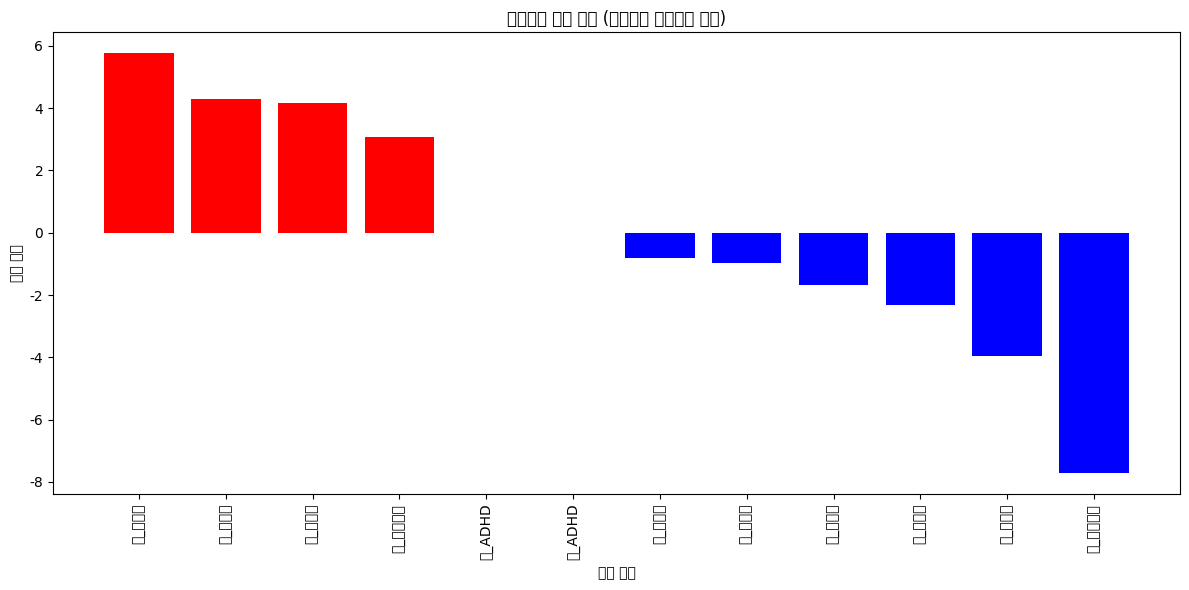

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)
print("정확도:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
import numpy as np

coefficients = model.coef_[0]
feature_names = X.columns
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefficients})
coef_df_sorted = coef_df.sort_values("coef", ascending=False)

colors = ["red" if c > 0 else "blue" for c in coef_df_sorted["coef"]]

plt.figure(figsize=(12, 6))
plt.bar(coef_df_sorted["feature"], coef_df_sorted["coef"], color=colors)
plt.xticks(rotation=90)
plt.title("로지스틱 회귀 계수 (정신질환 구성비의 영향)")
plt.xlabel("질환 조합")
plt.ylabel("회귀 계수")
plt.tight_layout()
plt.show()